# Introducción

Hoy en día es importante para los negocios conocer los perfiles de sus clientes, para así tener claro quiénes son sus clientes, qué compran, cuándo compran, en qué medios digitales se mueven para planificar mejores estrategias comerciales.

Ahí es donde la segmentación de clientes entra en juego, y gracias a la cantidad de datos que los negocios manejan se pueden aplicar algoritmos de Machine Learning para segmentar nuestros clientes.

En este proyecto se utilizará el algoritmo K-means clustering para agrupar clientes según sus características.

# Objetivos

- Realizar el preprocesamiento de los datos para poder aplicar el modelo
- Construir e implementar K-means utilizando Sklearn
- Evaluar el modelo para definir el número óptimo de grupos de clientes
- Visualizar las características de cada grupo de clientes
- Recomendaciones de negocio para cada segmento de clientes

# Proceso de ciencia de datos

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print('Libraries imported')

Libraries imported


## Extraer datos

In [2]:
df_customers = pd.read_csv('../data/Mall_Customers.csv')
df_customers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## Limpiar datos

Se removerá la columna 'CustomerID' ya que no aporta información sobre el cliente

In [3]:
df_customers = df_customers.drop(['CustomerID'], axis=1)
df_customers.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [4]:
df_customers.isnull().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

El dataset no presenta datos nulos

## Transformar datos

### Variables numéricas

Se procede a normalizar las variables numéricas del modelo usando StandardScaler de Sklearn, este método hace que los datos de cada columna tenga 0 como promedio y ayuda a que el modelo sea más efectivo

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
numerical_columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
numerical_data = df_customers[numerical_columns]
scaler = StandardScaler().fit(numerical_data.values)
numerical_data = scaler.transform(numerical_data.values)
scaled_num_data = pd.DataFrame(numerical_data, columns=numerical_columns)
scaled_num_data.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


### Variables categóricas

Las variables categóricas las transformamos a número para que puedan ingresar al modelo, en este caso 1 indicará que el cliente es del sexo femenino y 0 si es masculino.

In [7]:
gender = df_customers['Gender']
df = scaled_num_data.join(gender)
df = pd.get_dummies(df)
df = df.drop(['Gender_Male'], axis=1)
df.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female
0,-1.424569,-1.738999,-0.434801,0
1,-1.281035,-1.738999,1.195704,0
2,-1.352802,-1.700830,-1.715913,1
3,-1.137502,-1.700830,1.040418,1
4,-0.563369,-1.662660,-0.395980,1


## Explorar data

In [8]:
df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,2.000000e+02,2.000000e+02,2.000000e+02
mean,-1.021405e-16,-2.131628e-16,-1.465494e-16
std,1.002509e+00,1.002509e+00,1.002509e+00
min,-1.496335e+00,-1.738999e+00,-1.910021e+00
25%,-7.248436e-01,-7.275093e-01,-5.997931e-01
50%,-2.045351e-01,3.587926e-02,-7.764312e-03
75%,7.284319e-01,6.656748e-01,8.851316e-01
max,2.235532e+00,2.917671e+00,1.894492e+00


Se observa que el dataset no tiene valores atípicos

### Matriz de covarianza

La matriz de covarianza muestra si los datos están relacionados o son dependientes, en el caso de que lo fueran se podría eliminar una de las características para reducir la dimensionalidad de los datos de entrada.

In [9]:
covariance_matrix = np.cov(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].T)
covariance_matrix

array([[ 1.00502513, -0.01246034, -0.3288712 ],
       [-0.01246034,  1.00502513,  0.00995261],
       [-0.3288712 ,  0.00995261,  1.00502513]])

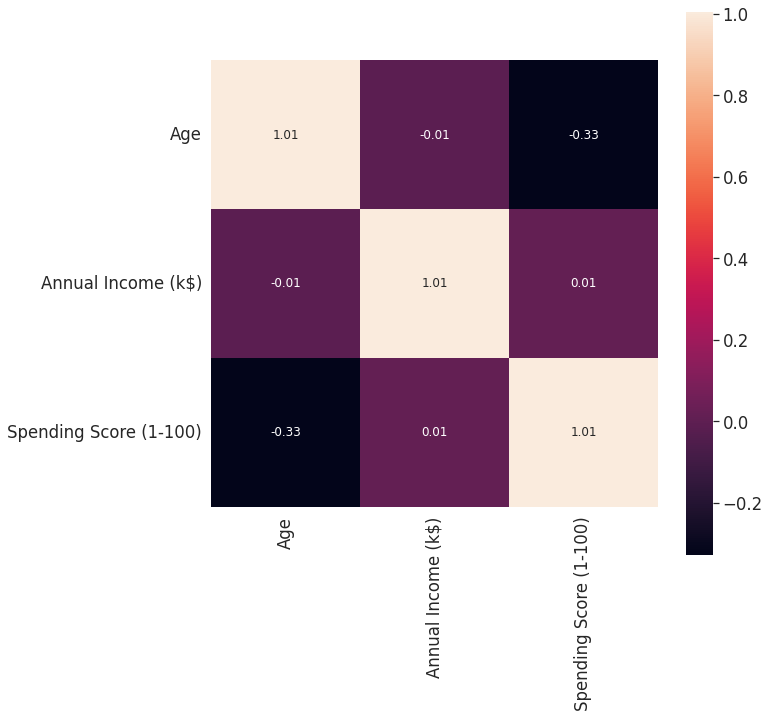

In [10]:
import seaborn as sns

plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
hm = sns.heatmap(covariance_matrix,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size': 12},
                yticklabels=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'],
                xticklabels=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])

La matriz de covarianza muestra que las variables no están tan correlacionadas. La única relación que se observa es entre la edad y el score de gasto con una correlación de -0.33. Lo cual indica que hay perfiles que a mayor edad gastan menos.

### PCA

Veamos si le podemos reducir la dimensionalidad del dataset utilizando Principal Components Analysis

[0.4095285  0.3081674  0.20723465 0.07506945]


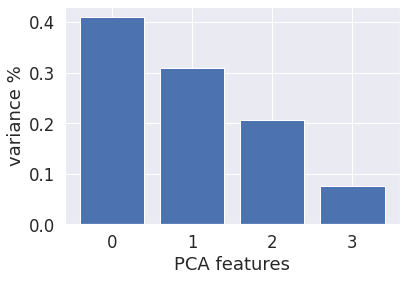

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
principal_components = pca.fit_transform(df)
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
print(pca.explained_variance_ratio_)

PCA_components = pd.DataFrame(principal_components)

Como vemos los primeros 3 componentes de PCA explican el 90% de la varianza del dataset por lo que podemos excluir el 4 componente que es el género

## Implementar modelo

Utilizaremos K-means para segmentar los datos

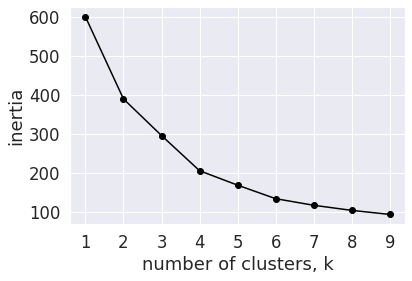

In [12]:
from sklearn.cluster import KMeans

ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:3])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Utilizando el método del codo en la figura anterior, el número óptimo de clusters parece ser de 4

Ahora que tenemos el número ideal de clusters, hagamos las predicciones para la data.

In [13]:
df = pd.read_csv('../data/Mall_Customers.csv')
df = df.drop(['CustomerID'],axis=1)

model = KMeans(n_clusters=4)
model.fit(PCA_components.iloc[:,:3])

k_predict = model.predict(PCA_components.iloc[:,:3])
frame = pd.DataFrame(df)
frame['cluster'] = k_predict
frame.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,0
1,Male,21,15,81,0
2,Female,20,16,6,0
3,Female,23,16,77,0
4,Female,31,17,40,0


Para ver la tendencia de comportamiento de estos 3 grupos, encontremos el promedio de las variables de cada cluster

In [14]:
avg_df = df.groupby(['cluster'], as_index=False).mean()
avg_df

,cluster,Age,Annual Income (k$),Spending Score (1-100)
0,0,25.438596,40.000000,60.298246
1,1,53.984615,47.707692,39.969231
2,2,32.875000,86.100000,81.525000
3,3,39.368421,86.500000,19.578947


<AxesSubplot:xlabel='cluster', ylabel='Annual Income (k$)'>

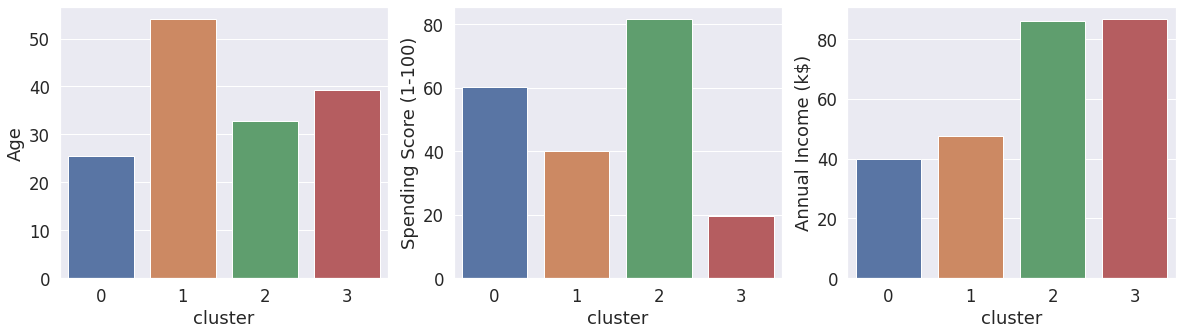

In [15]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

sns.barplot(x='cluster',y='Age',data=avg_df, ax=ax[0])
sns.barplot(x='cluster',y='Spending Score (1-100)',data=avg_df, ax=ax[1])
sns.barplot(x='cluster',y='Annual Income (k$)',data=avg_df, ax=ax[2])

Analizemos la distribución de género en los clusters y el dataset

In [16]:
df2 = pd.DataFrame(df.groupby(['cluster','Gender'])['Gender'].count())
df2

Gender
cluster Gender        
0       Female      34
        Male        23
1       Female      37
        Male        28
2       Female      22
        Male        18
3       Female      19
        Male        19

In [17]:
df3 = pd.DataFrame(df.groupby(['Gender'])['Gender'].count())
df3

,Gender
Gender,
Female,112
Male,88


En general, el dataset tiene más datos de mujeres y lo mismo se refleja en cada uno de los clusters por lo que el género no será de relevancia para caracterizar los clusters

## Interpretar resultados

### Características de cada cluster

Cluster 0:

    - Edad promedio 50 años
    - Bajo consumo (40 score de gasto)
    - Ingreso anual de bajo a medio
>

Cluster 1:

    - Edad promedio de 30 años
    - Alto consumo (80 score de gasto)
    - Altos ingresos anuales
>

Cluster 2:

    - Edad promedio de 25 años
    - Mediano consumo (60 score de gasto)
    - Bajo ingreso anual
>

Cluster 3:
    
    - Edad promedio de 40 años
    - Bajo consumo
    - Altos ingresos anuales 


## Recomendaciones según los perfiles de los clientes

### Cluster 0: En proceso de retiro

Personas adultas de 50 años con un ingreso regular y bajo consumo.
Son personas ahorradoras para su retiro.

Recomendaciones: La gran mayoría de estas personas se encuentran en Facebook, y se les podría promocionar productos para la salud.

### Cluster 1: Alto ingreso

Adultos jóvenes de 30 años con altos ingresos y alto consumo. Deben estar en una gran etapa de sus carreras y disfrutando de lo que ganan trabajando e iniciando vida en familia.

Recomendaciones: Con estos perfiles se puede ser más agresivos con la publicidad, y con productos de mayor precio. Además serían buen target para productos para bebes ya que inician la vida familiar.

### Cluster 2: Los compradores jóvenes

Aquí encontramos jóvenes de 25 años que llevan iniciando su vida laboral y a pesar de no tener tantos ingresos como otros grupos son altos consumidores.

Recomendaciones: Este grupo joven puede estar más interesado en ofertas de viajes y hoteles, también en productos que les proporcionen mayor estatus.

### Cluster 3: Los ahorradores

Adultos de 40 años con altos ingresos y bajo consumo, deben estar ahorrando para retirarse a más temprana edad o para la universidad de sus hijos.

Recomendaciones: Los descuentos podrían atraer a estas personas debido a su tendencia de gastar menos.



## Conclusiones

En este proyecto se utilizó el algoritmo de Kmeans para segmentar clientes con datos como la edad, ingreso anual, score de gasto. También se hizo la interpretación de cada cluster y cuáles son las características de las personas de cada cluster.

Finalmente se hizo recomendaciones para el negocio para cada perfil identificado.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=246fa214-d73c-42c3-9780-c1f3dc076381' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>